# Download a data file from the UCL server

We're using a small [example data set](http://data.cortexlab.net/singlePhase3/) recorded by [Nick Steinmetz](http://www.nicksteinmetz.com/) at UCL.

In [1]:
# thanks: https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads
import requests, sys, os
file_url = 'http://data.cortexlab.net/singlePhase3/data/rawDataSample.bin'
file_name = file_url.split('/')[-1]
if not os.path.isfile(file_name):
    with open(file_name, "wb") as f:
        response = requests.get(file_url, stream=True)
        total_length = response.headers.get('content-length',0)
        print("Downloading %d MB from %s" % (int(total_length)/1024/1024,file_url))
        if total_length is None: # no content length header
            print('Could not download the file1')
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=1024):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)
                sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                sys.stdout.flush()
else:
    print('File already downloaded (?)')

File already downloaded (?)


# Use of the `HSDetection` class

In [2]:
import sys
sys.path.append('..')
from hs2 import HSDetection
from probe import NeuroPixel
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

/disk/scratch/mhennig/venvs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/disk/scratch/mhennig/venvs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# raw data location (as downloaded above)
data_path = file_name

# detection parameters
to_localize = True
cutout_start = 6
cutout_end = 30
threshold = 22
file_name = 'ProcessedSpikesNeuropixel'

In [4]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name,save_all=True)

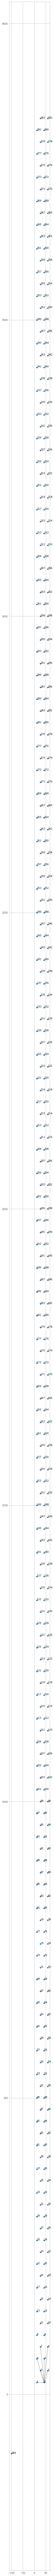

In [5]:
Probe.show([0])

In [6]:
H.DetectFromRaw()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# t0:50000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 49958 to 100055
# t0:100000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 99958 to 150055
# t0:150000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 149958 to 200055
# t0:200000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 199958 to 250055
# t0:250000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 249958 to 300055
# t0:300000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 299958 to 350055
# t0:350000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 349958 to 400055
# t0:400000 tcut2:55 tInc:50000
# Analysing 50000 frames; from 399958 to 450055
# t0:450000 tcut2:55 tInc:50000
# An

In [7]:
H.LoadDetected()

Detected and read 113268 spikes.


Spike detected at channel:  257
Spike detected at frame:  30529
35.904 2585.163


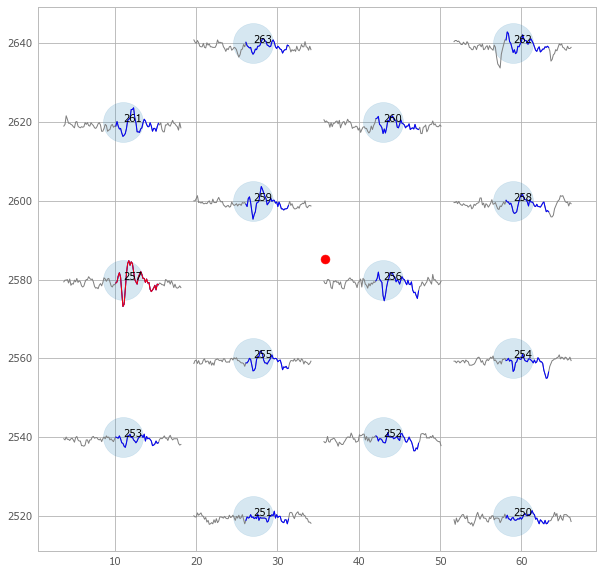

In [8]:
plt.figure(figsize=(10, 10))
H.PlotTracesChannels(2000, window_size=100)

(0, 500)

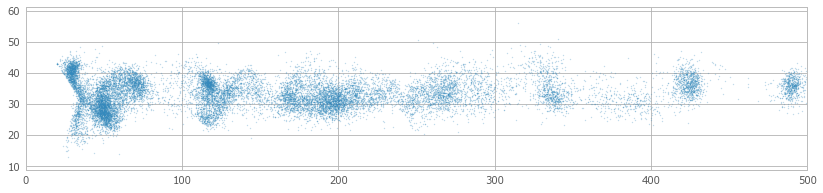

In [9]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(111)
H.PlotAll(invert=True, s=1, alpha=0.2, ax=ax)
ax.set_xlim((0,500))

# Use of the `HSClustering` class

In [10]:
from hs2 import HSClustering
# Load from file
#C = Clustering(['results/ProcessedSpikes_mea1k.bin', 'results/ProcessedSpikes_mea1k.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [11]:
%%time
C.ShapePCA(pca_ncomponents=2, pca_whiten=True);

Fitting PCA using 113268 spikes...
CPU times: user 1.75 s, sys: 110 ms, total: 1.86 s
Wall time: 391 ms


array([[ 1.33128863, -0.40896452],
       [ 0.48541579,  0.96474385],
       [-0.20269795,  0.79809797],
       ...,
       [-0.72126953, -1.5635391 ],
       [-0.09676766,  1.35530142],
       [ 1.63772177, -0.07995759]])

In [12]:
%%time
C.CombinedClustering(alpha=5, bandwidth=5., bin_seeding=False, n_jobs=-1,cluster_subset=50000)

Clustering...
Clustering using 50000 out of 113268  spikes...
number of seeds: 50000
seeds/job: 4167
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   28.6s remaining:  1.4min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   29.2s remaining:    5.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   29.3s finished


Predicting cluster labels for 113268 spikes...
Number of estimated clusters: 1910
CPU times: user 16.6 s, sys: 1.03 s, total: 17.7 s
Wall time: 34.9 s


We have 113268 spikes, only showing 100000


(0, 500)

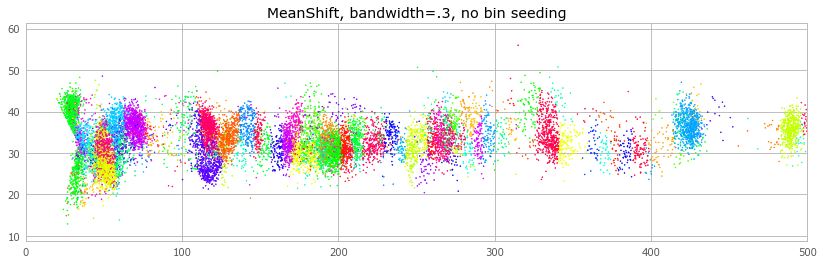

In [13]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(111)
C.PlotAll(invert=True, s=1, ax=ax, max_show=100000,show_labels=False)
plt.title("MeanShift, bandwidth=.3, no bin seeding");
ax.set_xlim((0,500))


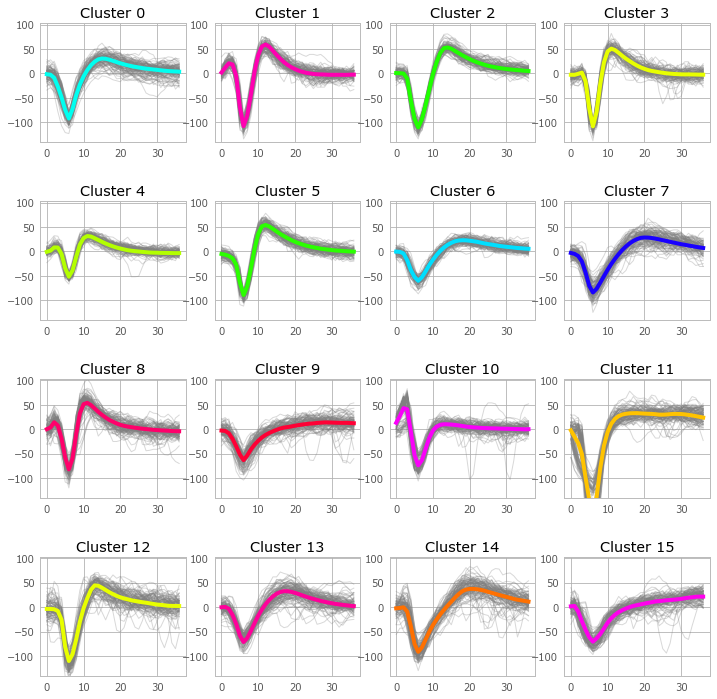

In [14]:
units = range(16)
C.PlotShapes(units)

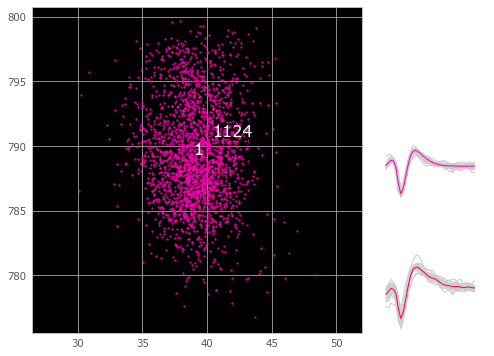

In [15]:
C.PlotNeighbourhood(1,radius=2, alpha=0.8);

In [16]:
# save results:
C.SaveHDF5(file_name+"_sorted.hdf5")